## Simple demonstration of statistical arbitrage
Implementation using a rolling window

In [1]:
from numpy import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbs
sbs.set()
%matplotlib inline

In [2]:
# read prices
Pe = pd.read_csv('data/JPM.csv')
Pb = pd.read_csv('data/XLF.csv')

In [3]:
# ensure the dates match up
matched_data = pd.merge(Pe, Pb, on = 'date')
matched_data = matched_data.sort_values(by=['date'], ascending = True).reset_index()

# use adjusted close prices for the study
price_e = matched_data['adjclose_x'].values
price_b = matched_data['adjclose_y'].values

In [4]:
# compute the (daily) return rate
Re = diff(price_e) / price_e[:-1]
Rb = diff(price_b) / price_b[:-1]

# time interval = daily (~252 trading days in a year)
dt = 1.0 / 252

#### price evolution equation
$$ R_e(t) = \alpha \cdot dt + \beta \cdot R_b(t) + dX(t) $$

### Modeled as Ornstein-Uhlenbeck process
$$ dX = \kappa*(m - X)*dt + \sigma*dW$$

in discrete form:
 $$ X[i+1] - X[i] = \kappa*(m - X[i])*dt + \sigma*sqrt(t)*dW $$
or
 $$ X[i+1] = X[i]*(1-\kappa*dt) + \kappa*m*dt + \sigma*sqrt(t)*dW $$

In [5]:
# make into a function
def compute_current_z(Rb, Re, dt = 1.0 / 252):
    # use linear regression to find alpha and beta
    beta, alphaXdt = polyfit(Rb, Re, 1)
    alpha = alphaXdt / dt

    # detrending to find dX
    R_fit = polyval([beta, alphaXdt], Rb)
    dX = R_fit - Re

    # modeling X
    X = cumsum(dX)

    # ensure that X[-1] = 0
    assert X[-1] <= 0.001 

    # compute Z-value
    m_prac        = mean(X)
    sigma_eq_prac =  std(X)
    z_prac = (X - m_prac) / sigma_eq_prac

    return z_prac[-1]
# end def

In [6]:
# compute value in rolling windows
window_size = 60
Zs = []
for i in range(len(price_e) - window_size + 1):
    z = compute_current_z(Rb[i:i+window_size], Re[i:i+window_size], dt)
    Zs.append(z)
# end for

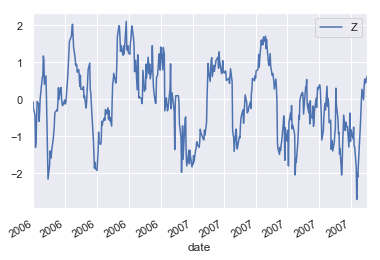

In [7]:
# plotting
z_series = pd.Series(Zs, index = matched_data['date'].index[-len(Zs):], name = 'Z', dtype=float64)
D = pd.DataFrame({'date': matched_data['date'][-len(Zs):], 'Z': z_series})
D['date'] = pd.to_datetime(D['date'])
D.plot(
    x='date', y='Z', 
    xticks = pd.date_range(D['date'].values[0], D['date'].values[-1], freq = '2M'),
    xlim = [matched_data['date'].values[-len(Zs)], matched_data['date'].values[-1]],
);